In [72]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt
import keras.backend as K
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pickle
import itertools
import cv2

In [48]:
os.getcwd()+'\\train'

'E:\\Technical\\Machine Learning\\Projects\\FER\\train'

In [49]:
IMG_SIZE=(48,48)
IMG_SHAPE=IMG_SIZE+(3,)
BATCH_SIZE=100
PATIENCE=10

train_dir=os.getcwd()+'\\train'
test_dir=os.getcwd()+'\\test'

In [50]:
train_gen=ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,
    rotation_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_gen=ImageDataGenerator(
    rescale=1./255,
)

In [51]:
train_dataset=train_gen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

test_dataset=test_gen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [52]:
classes=os.listdir(train_dir)

In [53]:
from IPython.display import HTML

In [54]:
len(os.listdir(train_dir+'\\'+classes[0]))

3995

In [55]:
x='\\'
print('Train:')
for clas in classes:
    print(f"{clas}:{len(os.listdir(train_dir+x+clas))}")

Train:
angry:3995
disgust:436
fear:4097
happy:7215
neutral:4965
sad:4830
surprise:3171


In [56]:
x='\\'
print('Test:')
for clas in classes:
    print(f"{clas}:{len(os.listdir(test_dir+x+clas))}")

Test:
angry:958
disgust:111
fear:1024
happy:1774
neutral:1233
sad:1247
surprise:831


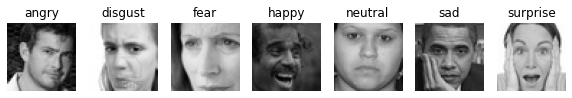

In [57]:
x='\\'
plt.figure(figsize=(10,10))
i=1
for clas in classes:
    img=load_img(train_dir+x+clas+'\\'+os.listdir(train_dir+x+clas)[1])
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(clas)
    i+=1
plt.show()

In [73]:
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,BatchNormalization,GlobalAveragePooling2D,Dropout
from tensorflow.keras import Sequential,regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

In [59]:
trial_model=Sequential([
    Conv2D(64,(3,3),activation='relu',input_shape=IMG_SHAPE),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(7,activation='softmax')
])

In [60]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [61]:
trial_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS)

In [62]:
trial_model.fit(train_dataset,epochs=2)

Epoch 1/2
288/288 [==============================] - 227s 780ms/step - loss: 1.7488 - accuracy: 0.8573 - precision: 0.5323 - recall: 0.0072 - auc: 0.6956 - f1_score: 0.0141
Epoch 2/2
288/288 [==============================] - 30s 105ms/step - loss: 1.6594 - accuracy: 0.8595 - precision: 0.6245 - recall: 0.0412 - auc: 0.7393 - f1_score: 0.0758


In [63]:
train_evaluation=trial_model.evaluate(train_dataset)
test_evaluation=trial_model.evaluate(test_dataset)

72/72 [==============================] - 14s 194ms/step - loss: 1.5521 - accuracy: 0.8678 - precision: 0.7032 - recall: 0.1287 - auc: 0.7780 - f1_score: 0.2160


# Testing on some Images

Prediction:surprise


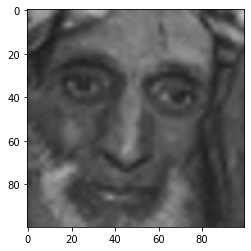

In [64]:
img=load_img(train_dir+'\\sad\\'+os.listdir(train_dir+'\\sad')[4])
plt.imshow(img.resize((100,100)))
img_arr=image.img_to_array(img)
arr=np.expand_dims(img_arr,0)
print(f'Prediction:{classes[np.argmax(trial_model.predict(arr))]}')

Prediction:fear


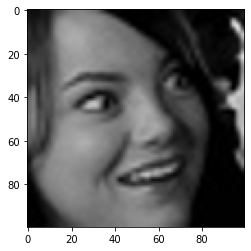

In [65]:
img=load_img(train_dir+'\\happy\\'+os.listdir(train_dir+'\\happy')[2])
plt.imshow(img.resize((100,100)))
img_arr=image.img_to_array(img)
arr=np.expand_dims(img_arr,0)
print(f'Prediction:{classes[np.argmax(trial_model.predict(arr))]}')

In [69]:
base_model=tf.keras.applications.VGG16(include_top=False,input_shape=IMG_SHAPE,weights='imagenet')

In [70]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [74]:
model=Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7,activation='softmax')
])

In [75]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1, 512)         2048      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)              

In [76]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS)

In [77]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=20)
counter=Counter(train_dataset.classes)
max_val=max(counter.values())
class_weights={class_id:round(max_val/weights,2) for class_id,weights in counter.items()}

In [78]:
model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=100,
          callbacks=[lrd,mcp,es],
          class_weight=class_weights
         )

Epoch 1/100
288/288 [==============================] - 70s 217ms/step - loss: 4.7275 - accuracy: 0.8425 - precision: 0.2545 - recall: 0.0529 - auc: 0.5714 - f1_score: 0.0542 - val_loss: 2.8804 - val_accuracy: 0.8270 - val_precision: 0.2006 - val_recall: 0.0706 - val_auc: 0.5634 - val_f1_score: 0.1042
Epoch 2/100
288/288 [==============================] - 60s 207ms/step - loss: 4.0258 - accuracy: 0.8502 - precision: 0.1856 - recall: 0.0144 - auc: 0.5451 - f1_score: 0.0264 - val_loss: 2.2904 - val_accuracy: 0.8571 - val_precision: 0.5000 - val_recall: 2.7863e-04 - val_auc: 0.5795 - val_f1_score: 5.5005e-04
Epoch 3/100
288/288 [==============================] - 61s 212ms/step - loss: 3.7168 - accuracy: 0.8543 - precision: 0.3000 - recall: 0.0147 - auc: 0.5810 - f1_score: 0.0278 - val_loss: 3.3166 - val_accuracy: 0.7649 - val_precision: 0.1744 - val_recall: 0.1729 - val_auc: 0.5748 - val_f1_score: 0.1736
Epoch 4/100
288/288 [==============================] - 61s 211ms/step - loss: 3.5567 -

Epoch 47/100
288/288 [==============================] - 50s 172ms/step - loss: 1.5111 - accuracy: 0.9146 - precision: 0.7779 - recall: 0.5631 - auc: 0.9327 - f1_score: 0.6526 - val_loss: 1.1252 - val_accuracy: 0.8995 - val_precision: 0.7005 - val_recall: 0.5176 - val_auc: 0.9083 - val_f1_score: 0.5947
Epoch 48/100
288/288 [==============================] - 50s 172ms/step - loss: 1.4843 - accuracy: 0.9152 - precision: 0.7795 - recall: 0.5670 - auc: 0.9343 - f1_score: 0.6560 - val_loss: 1.1681 - val_accuracy: 0.8979 - val_precision: 0.7056 - val_recall: 0.4901 - val_auc: 0.8985 - val_f1_score: 0.5778
Epoch 49/100
288/288 [==============================] - 49s 171ms/step - loss: 1.4846 - accuracy: 0.9153 - precision: 0.7778 - recall: 0.5694 - auc: 0.9346 - f1_score: 0.6570 - val_loss: 1.1251 - val_accuracy: 0.9029 - val_precision: 0.6996 - val_recall: 0.5609 - val_auc: 0.9093 - val_f1_score: 0.6224
Epoch 50/100
288/288 [==============================] - 50s 173ms/step - loss: 1.4319 - acc

Prediction:fear


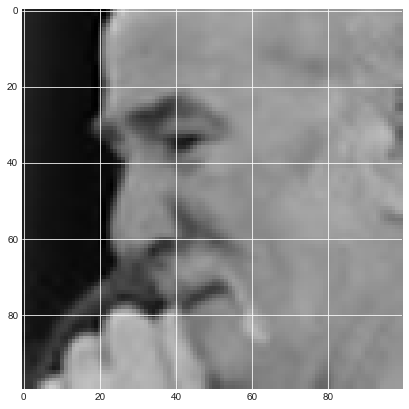

In [88]:
img=load_img(train_dir+'\\sad\\'+os.listdir(train_dir+'\\sad')[25])
plt.imshow(img.resize((100,100)))
img_arr=image.img_to_array(img)
arr=np.expand_dims(img_arr,0)
print(f'Prediction:{classes[np.argmax(model.predict(arr))]}')

In [80]:
y_true=test_dataset.classes
y_pred=model.predict(test_dataset)
y_pred=tf.argmax(y_pred,axis=1).numpy()

In [81]:
cm=confusion_matrix(y_true,y_pred)

Confusion matrix, without normalization

[[162   7 147 243 174 125 100]
 [ 18   3  13  26  23  17  11]
 [151  17 145 255 161 177 118]
 [263  20 269 434 318 273 197]
 [196  10 186 293 222 198 128]
 [207  19 181 278 228 195 139]
 [134  13 117 202 137 137  91]]





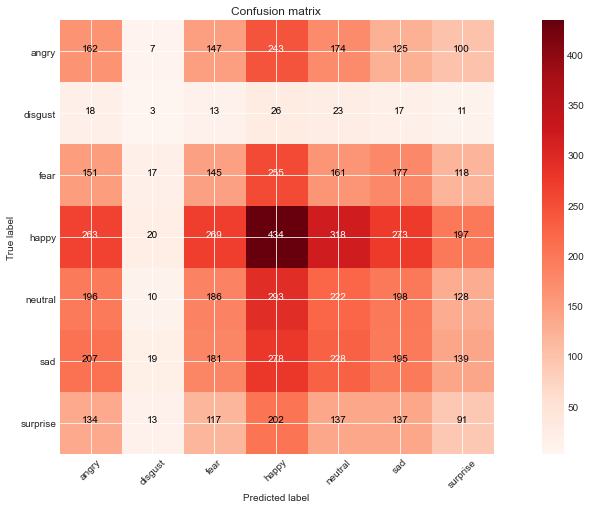

In [82]:
plt.rcParams['figure.figsize'] = (14,7)

plt.style.use('seaborn-darkgrid')
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)    

print('Confusion matrix, without normalization\n')   
print(cm)

print("\n\n")
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [89]:
train_evaluation_main=model.evaluate(train_dataset)
test_evaluation_main=model.evaluate(test_dataset)

72/72 [==============================] - 5s 63ms/step - loss: 1.1635 - accuracy: 0.9073 - precision: 0.6928 - recall: 0.6312 - auc: 0.9164 - f1_score: 0.6601


# Save Model

In [83]:
#filename='finalized_model.sav'
#pickle.dump(model,open(filename,'wb'))

#to load model
#model=pickle.load(filename,'rb')

In [23]:
#model.save_weights('model.h6')

In [92]:
from keras.models import load_model
model=load_model('model.h5',custom_objects={'f1_score':f1_score})

Prediction:happy


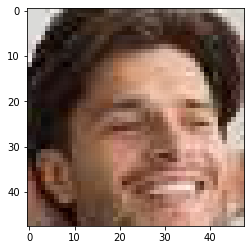

In [14]:
from PIL import Image
img=Image.open('happyguy.jpg')
cropped_img=img.crop((77,10,125,58))
plt.imshow(cropped_img)
arr=image.img_to_array(cropped_img)
img_arr=np.expand_dims(arr,0)
print(f'Prediction:{classes[np.argmax(model.predict(img_arr))]}')

# Face Detection

In [15]:
cv2.__path__

['C:\\Users\\avdho\\anaconda3\\lib\\site-packages\\cv2']

In [16]:
img=cv2.imread('happyguy.jpg')
gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces_rect=face_cascade.detectMultiScale(gray_img,1.1,9)


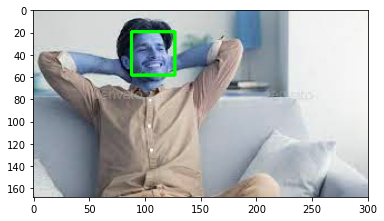

In [17]:
for (x,y,w,h) in faces_rect:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

plt.imshow(img)

Prediction:happy


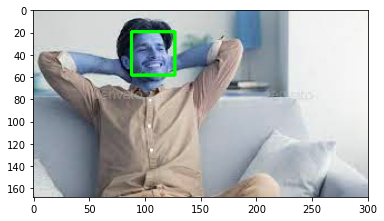

In [18]:
img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
roi_gray_img = img_rgb[y:y + h, x:x + w]
cropped_img = np.expand_dims(cv2.resize(roi_gray_img, (48, 48)), 0)
print(f'Prediction:{classes[np.argmax(model.predict(cropped_img))]}')
plt.imshow(img)

In [85]:
# font
font = cv2.FONT_HERSHEY_SIMPLEX
# fontScale
fontScale = 1
# Blue color in BGR
color = (255, 0, 0)
# Line thickness of 2 px
thickness = 2

In [86]:
cap=cv2.VideoCapture(0)
while True:
    ret,frame=cap.read()
    
    gray_frame=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces_rect=face_cascade.detectMultiScale(gray_frame,1.1,9)

    for (x,y,w,h) in faces_rect:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
        frame_rgb=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        roi_rgb_frame = frame_rgb[y:y + h, x:x + w]
        cropped_img = np.expand_dims(cv2.resize(roi_rgb_frame, (48, 48)), 0)
        
        
        cv2.putText(frame,classes[np.argmax(model.predict(cropped_img))],(x+20,y-60),font,fontScale,color,thickness,cv2.LINE_AA)
    
    cv2.imshow('frame',frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()